In [1]:
%load_ext cudf.pandas

# Grouped Computations

In this lesson, we discuss how to do scientific computations with defined "groups" of data
within our xarray objects. Our learning goals are as follows:

- Perform "split / apply / combine" workflows in Xarray using `groupby`,
  including
  - reductions within groups
  - transformations on groups
- Use `resample` to change the time frequency of the data


In [2]:
%%cudf.pandas.profile

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# don't expand data by default
xr.set_options(display_expand_data=False, display_expand_attrs=False)

%config InlineBackend.figure_format='retina'

                                                                                              
                                  Total time elapsed: 1.610 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

## Example Dataset

First we load a dataset. We will use the
[NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncei.noaa.gov/products/extended-reconstructed-sst)
product, a widely used and trusted gridded compilation of of historical data
going back to 1854.

In [3]:
%%cudf.pandas.profile

ds = xr.tutorial.load_dataset("ersstv5")
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (37)

                                                                                                               
                                           Total time elapsed: 9.557 seconds                                   
                                        303 GPU function calls in 0.133 seconds                                
                                        18 CPU function calls in 0.012 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ isna                      │ 0          │ 0.000       │ 0.000       │ 10         │ 0.006       │ 0.001       │
│ to_timedelta              │ 0          │ 0.000       │ 0.000       │ 6          │ 0.005       │ 0.001       │
│ ndarray.reshape           │ 0          │ 0.000       │ 0.000       │ 2          │ 0.002       │ 0.001       │
│ Index                     │ 3          │ 0.008       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 178        │ 0.053       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__setattr__  │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 89         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__ │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.017       │ 0.009       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna
- to_timedelta
- ndarray.reshape

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=817609;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

## Groupby

Xarray copies Pandas' very useful groupby functionality, enabling the "split /
apply / combine" workflow on xarray DataArrays and Datasets.

Let's examine a timeseries of SST at
a single point.


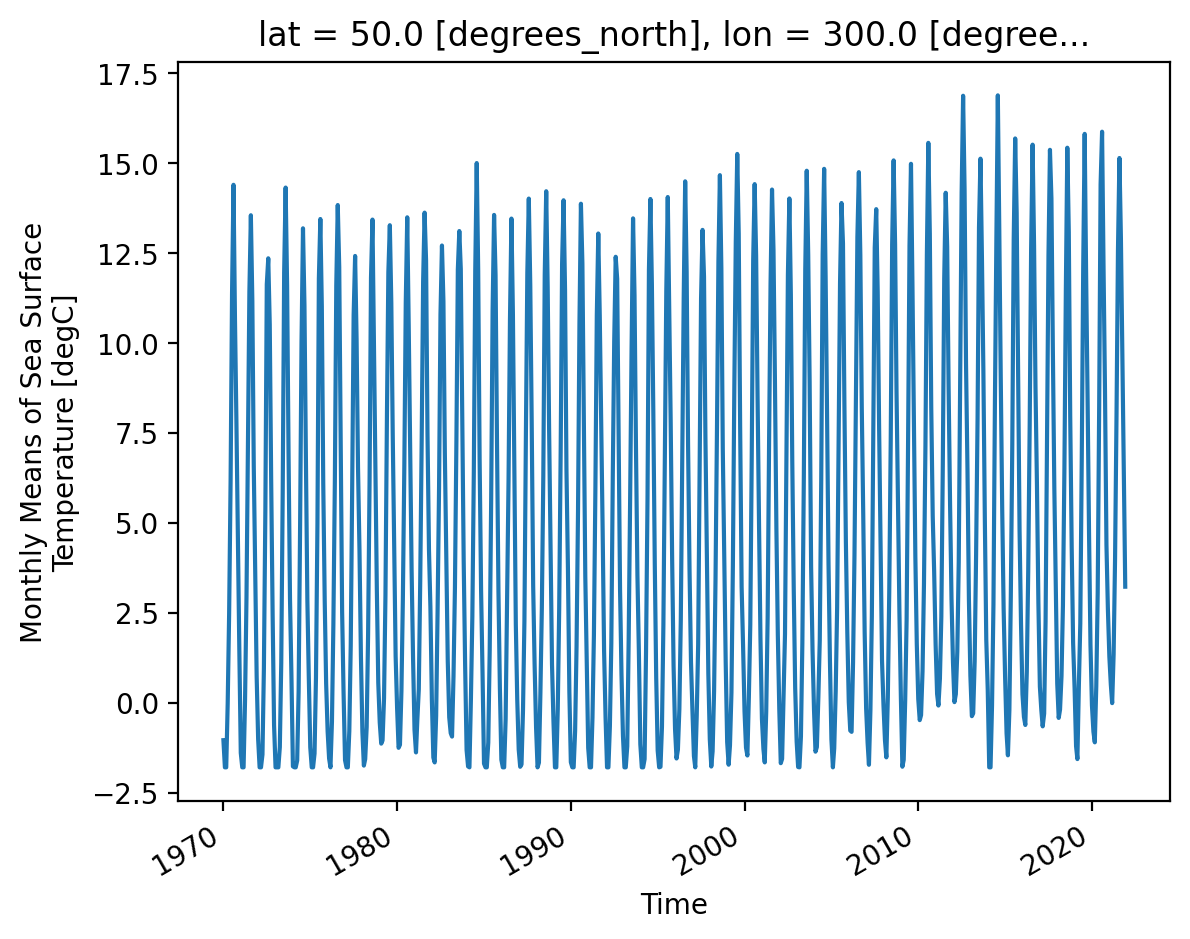

                                                                                                              
                                          Total time elapsed: 4.557 seconds                                   
                                        23 GPU function calls in 0.008 seconds                                
                                        2 CPU function calls in 0.011 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__     │ 4          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__    │ 16         │ 0.005       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.get_loc     │ 0          │ 0.000       │ 0.000       │ 2          │ 0.011       │ 0.006       │
│ Float32Index.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy       │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Float32Index.get_loc

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=951193;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [4]:
%%cudf.pandas.profile

ds.sst.sel(lon=300, lat=50).plot();

As we can see from the plot, the timeseries at any one point is totally
dominated by the seasonal cycle. We would like to remove this seasonal cycle
(called the "climatology") in order to better see the long-term variaitions in
temperature. We can accomplish this using **groupby**.

Before moving forward, we note that xarray correctly parsed the time index,
resulting in a Pandas datetime index on the time dimension.


In [5]:
%%cudf.pandas.profile

ds.time

<xarray.DataArray 'time' (time: 624)>
1970-01-01 1970-02-01 1970-03-01 1970-04-01 ... 2021-10-01 2021-11-01 2021-12-01
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Attributes: (7)

                                                                                                               
                                           Total time elapsed: 0.244 seconds                                   
                                        184 GPU function calls in 0.070 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 171        │ 0.052       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

The syntax of Xarray's groupby is almost identical to Pandas.


In [6]:
%%cudf.pandas.profile

?ds.groupby

                                                                                                               
                                           Total time elapsed: 1.856 seconds                                   
                                        72 GPU function calls in 0.025 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 44         │ 0.014       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 4          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 22         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

### Identifying groups

The most important argument is `group`: this defines the unique values or labels we will
us to "split" the data for grouped analysis. We can pass either a DataArray or a
name of a variable in the dataset. Let's first use a DataArray. 

Just like with
Pandas, we can use the time index to extract specific components of dates and
times. Xarray uses a special syntax for this `.dt`, called the
[DatetimeAccessor](https://docs.xarray.dev/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html?highlight=DatetimeAccessor). See the [documentation](https://docs.xarray.dev/en/stable/user-guide/time-series.html#datetime-components) for more


In [7]:
%%cudf.pandas.profile

ds.time.dt

                                                                                              
                                  Total time elapsed: 0.039 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [8]:
%%cudf.pandas.profile

ds.time.dt.month

<xarray.DataArray 'month' (time: 624)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 ... 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Attributes: (7)

                                                                                                               
                                           Total time elapsed: 0.371 seconds                                   
                                        192 GPU function calls in 0.181 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 76         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape           │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype            │ 1          │ 0.104       │ 0.104       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 98         │ 0.032       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__    │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [9]:
%%cudf.pandas.profile

ds.time.dt.year

<xarray.DataArray 'year' (time: 624)>
1970 1970 1970 1970 1970 1970 1970 1970 ... 2021 2021 2021 2021 2021 2021 2021
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Attributes: (7)

                                                                                                               
                                           Total time elapsed: 0.263 seconds                                   
                                        192 GPU function calls in 0.077 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 76         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape           │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype            │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 98         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__    │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

### Split step

We can use these arrays in a groupby operation:


In [10]:
%%cudf.pandas.profile

gb = ds.groupby(ds.time.dt.month)
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

                                                                                                             
                                          Total time elapsed: 0.158 seconds                                  
                                       79 GPU function calls in 0.036 seconds                                
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__   │ 18         │ 0.005       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                  │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype          │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                   │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 36         │ 0.011       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__    │ 12         │ 0.004       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy      │ 3          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names    │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize               │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Xarray also offers a more concise syntax when the variable you're grouping on is
already present in the dataset. This is identical to the previous line:


In [11]:
%%cudf.pandas.profile

gb = ds.groupby("time.month")
gb

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

                                                                                                                
                                           Total time elapsed: 0.145 seconds                                    
                                         79 GPU function calls in 0.038 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 37         │ 0.014       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 3          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 29         │ 0.009       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__     │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

`gb` is a DatasetGroupBy object. It represents a GroupBy operation and helpfully tells us the unique "groups" or labels found during the split step.


```{tip}

Xarrays' computation methods (`groupby`, `groupby_bins`, `rolling`, `coarsen`, `weighted`) all return special objects that represent the basic underlying computation pattern. For e.g. `gb` above is a `DatasetGroupBy` object that represents monthly groupings of the data in `ds` . It is usually helpful to save and reuse these objects for multiple operations (e.g. a mean and standard deviation calculation).
```

### Apply & Combine

Now that we have groups defined, it's time to "apply" a calculation to the
group. Like in Pandas, these calculations can either be:

- _aggregation_ or _reduction_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, xarray will automatically combine the aggregated
/ transformed groups back into a single object.

#### Aggregations or Reductions

Most commonly, we want to perform a reduction operation like `sum` or `mean` on our groups. Xarray conveniently provides these reduction methods on Groupby objects for both [DataArrays and Datasets](https://docs.xarray.dev/en/stable/api.html#groupby-objects).

Here we calculate the monthly mean.

In [12]:
%%cudf.pandas.profile

ds_mm = gb.mean()
ds_mm

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, month: 12, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (month, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (37)

                                                                                                               
                                           Total time elapsed: 1.378 seconds                                   
                                       1099 GPU function calls in 0.461 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__getitem__ │ 13         │ 0.054       │ 0.004       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 65         │ 0.022       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 13         │ 0.005       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 50         │ 0.016       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__      │ 664        │ 0.214       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy         │ 52         │ 0.022       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals       │ 66         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__len__        │ 23         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.set_names    │ 44         │ 0.026       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.copy           │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__setattr__    │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 79         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy           │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__    │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__getitem__  │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__    │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__repr__     │ 2          │ 0.014       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__       │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

So we did what we wanted to do: calculate the climatology at every point in the
dataset. Let's look at the data a bit.

_Climatology at a specific point in the North Atlantic_


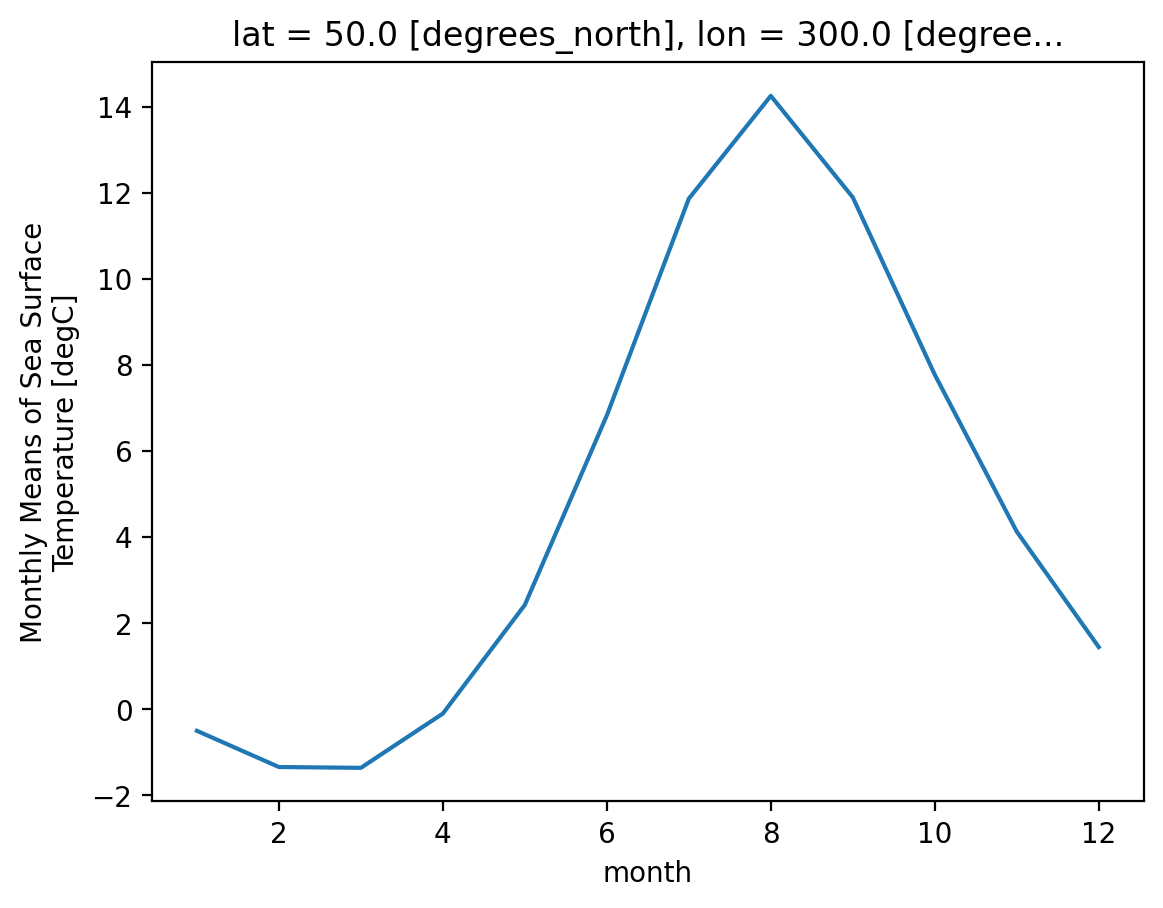

                                                                                                              
                                          Total time elapsed: 1.243 seconds                                   
                                        28 GPU function calls in 0.013 seconds                                
                                        1 CPU function calls in 0.006 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float64Index.__len__     │ 4          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 20         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.get_loc     │ 1          │ 0.004       │ 0.004       │ 1          │ 0.006       │ 0.006       │
│ Float64Index.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Float64Index.get_loc

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=626859;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [13]:
%%cudf.pandas.profile

ds_mm.sst.sel(lon=300, lat=50).plot();

_Zonal Mean Climatology_


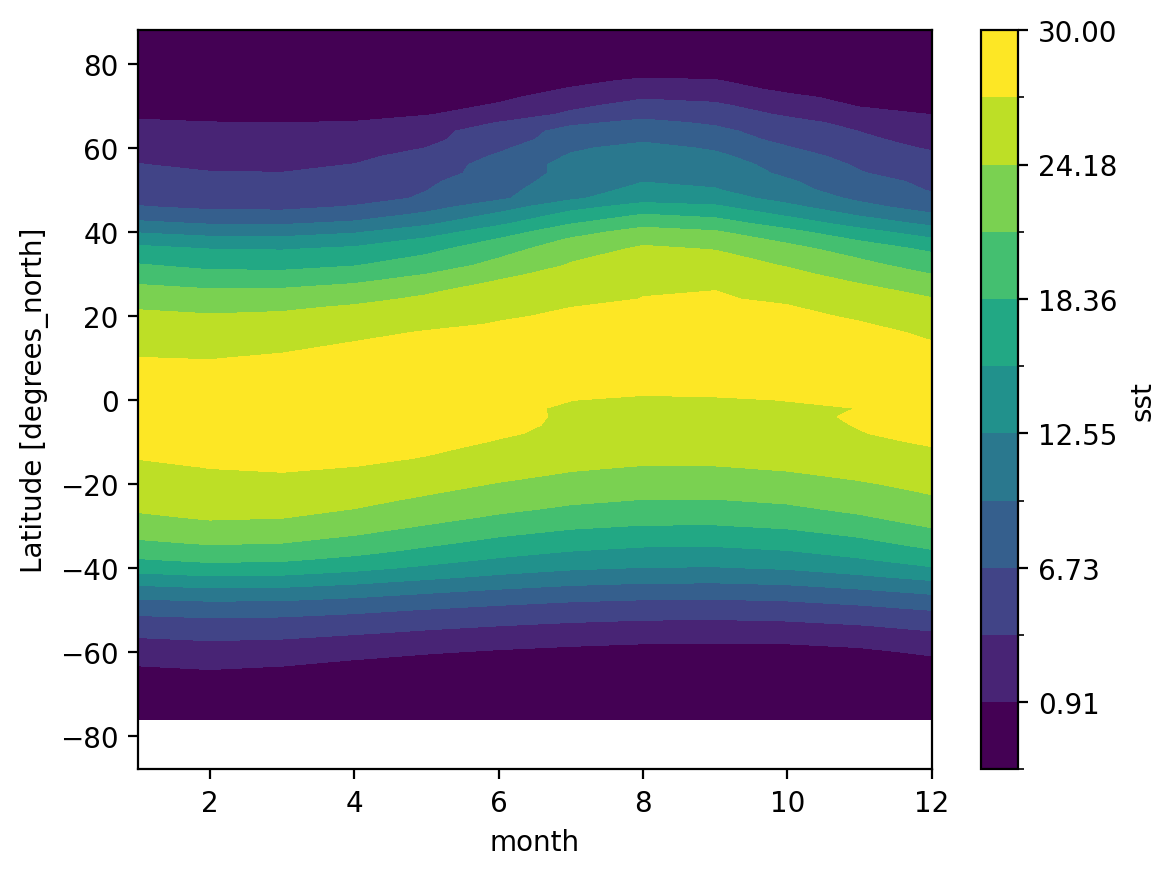

                                                                                                          
                                        Total time elapsed: 1.869 seconds                                 
                                      14 GPU function calls in 0.004 seconds                              
                                      1 CPU function calls in 0.001 seconds                               
                                                                                                          
                                                      Stats                                               
                                                                                                          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function             ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__len__   │ 7          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__ │ 7          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ isna                 │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
└──────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=205784;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [14]:
%%cudf.pandas.profile

ds_mm.sst.mean(dim="lon").plot.contourf(x="month", levels=12, vmin=-2, vmax=30);

_Difference between January and July Climatology_


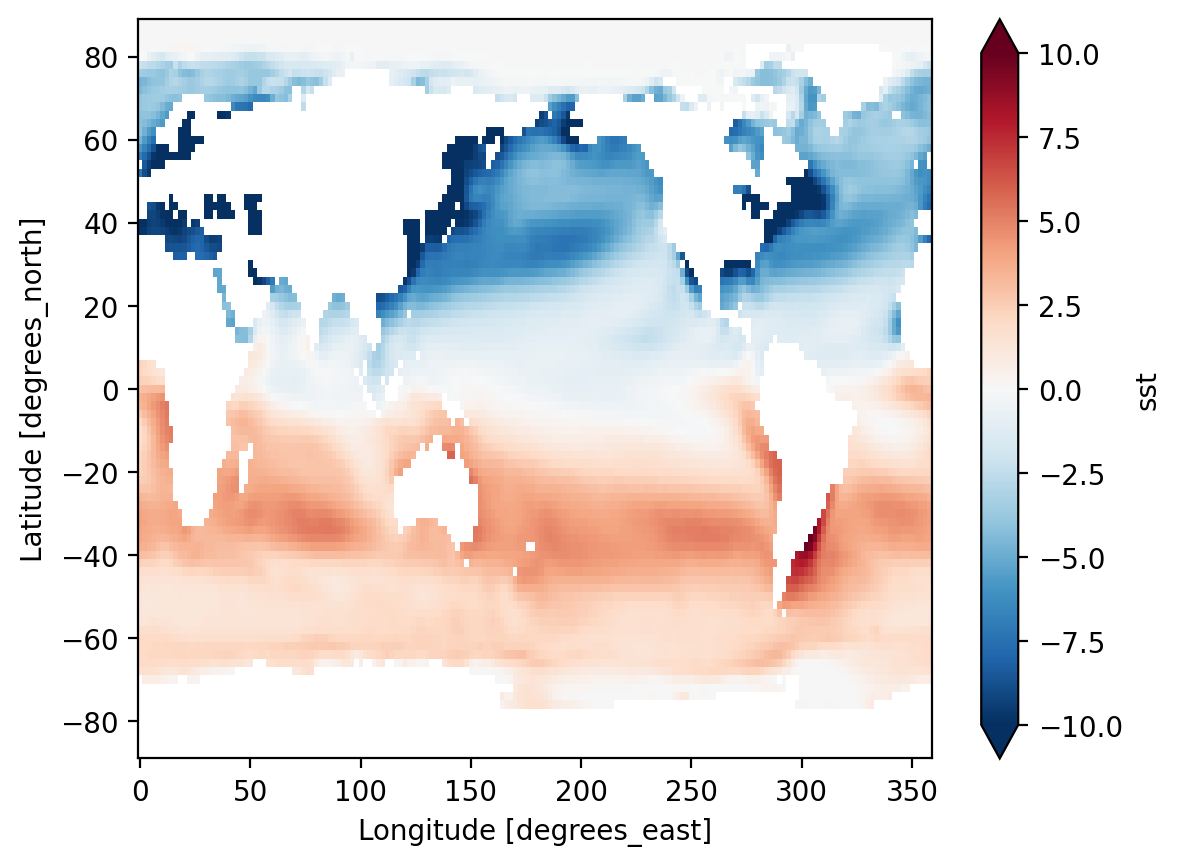

                                                                                                            
                                         Total time elapsed: 2.108 seconds                                  
                                      110 GPU function calls in 0.054 seconds                               
                                       1 CPU function calls in 0.001 seconds                                
                                                                                                            
                                                       Stats                                                
                                                                                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function               ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float64Index.__len__   │ 94         │ 0.036       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__     │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.get_loc     │ 2          │ 0.010       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy      │ 6          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals    │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ isna                   │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
└────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=30729;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [15]:
%%cudf.pandas.profile

(ds_mm.sst.sel(month=1) - ds_mm.sst.sel(month=7)).plot(vmax=10);

#### Custom Aggregations

The most fundamental way to apply a function and combine the results together to use the `.map` method.

In [16]:
%%cudf.pandas.profile

?gb.map

                                                                                                            
                                         Total time elapsed: 0.075 seconds                                  
                                       25 GPU function calls in 0.009 seconds                               
                                       0 CPU function calls in 0.000 seconds                                
                                                                                                            
                                                       Stats                                                
                                                                                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function               ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__len__     │ 23         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

`.map` accepts as its argument a function that expects and returns xarray
objects. We define a custom function. This function takes a single argument--the
group dataset--and returns a new dataset to be combined:

In [17]:
%%cudf.pandas.profile

def time_mean(a):
    return a.mean(dim="time")


gb.map(time_mean)

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, month: 12, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (month, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36
    sst        (month, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

                                                                                                               
                                           Total time elapsed: 1.407 seconds                                   
                                       1090 GPU function calls in 0.480 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__getitem__ │ 12         │ 0.056       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 60         │ 0.022       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 12         │ 0.005       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 48         │ 0.016       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__      │ 664        │ 0.226       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy         │ 52         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals       │ 66         │ 0.032       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__len__        │ 23         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.set_names    │ 44         │ 0.027       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.copy           │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__setattr__    │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 79         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy           │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__    │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__getitem__  │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__    │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__repr__     │ 2          │ 0.014       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__       │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

This is identical to `gb.mean()`

#### Apply by iteration

We can manually iterate over the group. The
iterator returns the key (group name) and the value (the actual dataset
corresponding to that group) for each group.


You could apply any function you want in the loop but you would have to manually [combine](https://docs.xarray.dev/en/stable/user-guide/combining.html) the results together.

In [18]:
%%cudf.pandas.profile

for group_name, group_ds in gb:
    # stop iterating after the first loop
    break
print(group_name)
group_ds

1


<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 52, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2021-01-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (37)

                                                                                                               
                                           Total time elapsed: 0.420 seconds                                   
                                        245 GPU function calls in 0.115 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__len__        │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 7          │ 0.011       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 76         │ 0.025       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 144        │ 0.048       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__repr__     │ 2          │ 0.013       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the
residual, called the _anomaly_, which is the interesting part from a climate
perspective. Removing the seasonal climatology is a perfect example of a
transformation: it operates over a group, but doesn't change the size of the
dataset. Here is one way to code it


In [19]:
%%cudf.pandas.profile

def remove_time_mean(x):
    return x - x.mean(dim="time")


ds_anom = ds.groupby("time.month").map(remove_time_mean)
ds_anom

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float32 5.96e-07 5.96e-07 5.96e-07 ... nan nan

                                                                                                                
                                           Total time elapsed: 2.699 seconds                                    
                                        2216 GPU function calls in 0.913 seconds                                
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 510        │ 0.186       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 55         │ 0.024       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 6          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 19         │ 0.061       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 432        │ 0.147       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__       │ 906        │ 0.312       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy          │ 100        │ 0.044       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals        │ 90         │ 0.046       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__len__         │ 23         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.set_names     │ 44         │ 0.028       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.append       │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.copy            │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__setattr__     │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__setattr__   │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__getitem__   │ 12         │ 0.012       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__repr__      │ 2          │ 0.015       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__     │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴──

Xarray makes these sorts of transformations easy by supporting _groupby
arithmetic_. This concept is easiest explained with an example:


In [20]:
%%cudf.pandas.profile

gb = ds.groupby("time.month")
ds_anom = gb - gb.mean()
ds_anom

../../thread/thread_load.cuh(36): warning: cuda.h: [jitify] File not found
../../thread/thread_store.cuh(36): warning: cuda.h: [jitify] File not found


<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float32 5.96e-07 5.96e-07 5.96e-07 ... nan nan

                                                                                                                
                                           Total time elapsed: 10.147 seconds                                   
                                        1435 GPU function calls in 8.977 seconds                                
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 201        │ 0.070       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 18         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 4          │ 0.004       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 143        │ 0.044       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 19         │ 0.057       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 74         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__       │ 732        │ 0.222       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy          │ 58         │ 0.022       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals        │ 70         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__len__         │ 23         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.set_names     │ 44         │ 0.024       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.copy            │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__setattr__     │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__setattr__   │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy            │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__     │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__    │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__eq__             │ 1          │ 0.223       │ 0.223       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any                │ 1          │ 8

Now we can view the climate signal without the overwhelming influence of the
seasonal cycle.

_Timeseries at a single point in the North Atlantic_


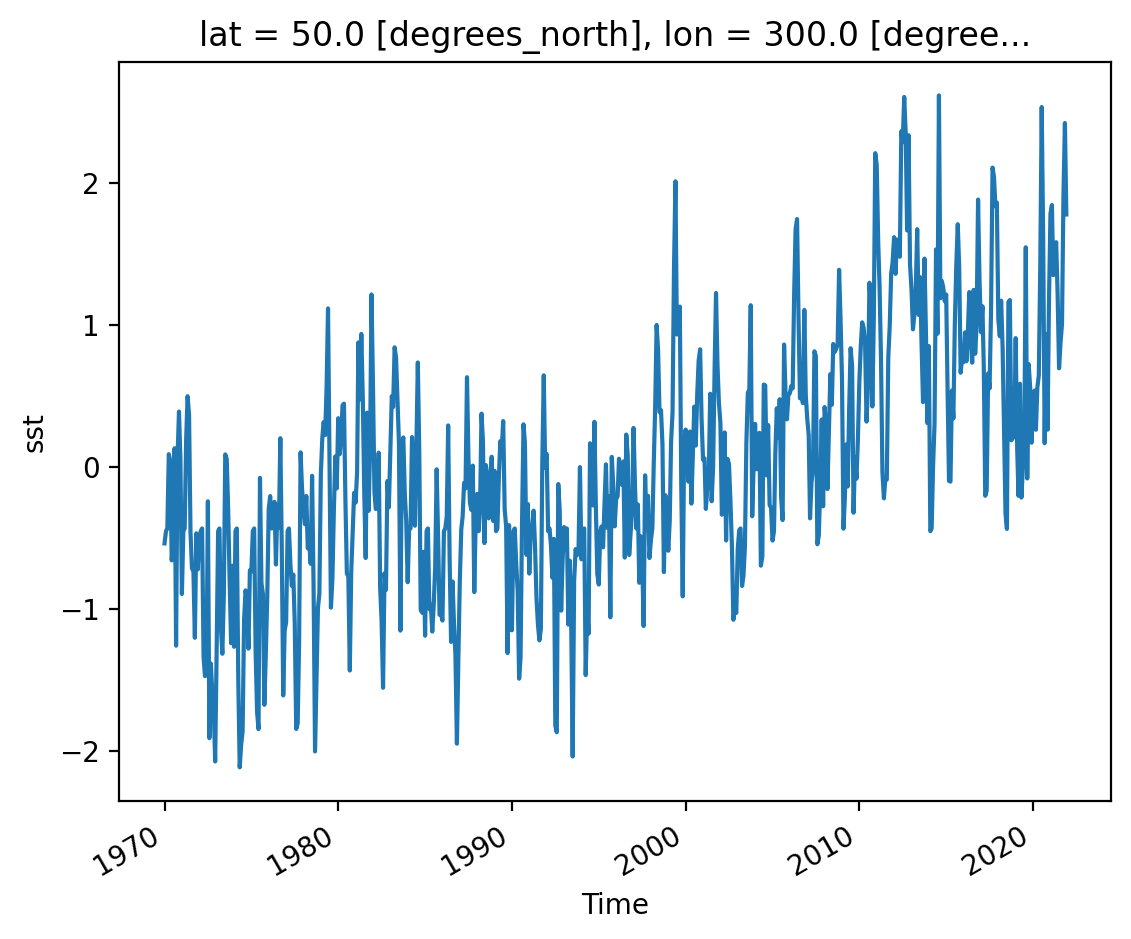

                                                                                                              
                                          Total time elapsed: 4.166 seconds                                   
                                        46 GPU function calls in 0.020 seconds                                
                                        1 CPU function calls in 0.007 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float64Index.__len__     │ 4          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__    │ 20         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 18         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.get_loc     │ 1          │ 0.004       │ 0.004       │ 1          │ 0.007       │ 0.007       │
│ Float64Index.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy       │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Float64Index.get_loc

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=634100;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [21]:
%%cudf.pandas.profile

ds_anom.sst.sel(lon=300, lat=50).plot();

_Difference between Jan. 1 2018 and Jan. 1 1970_


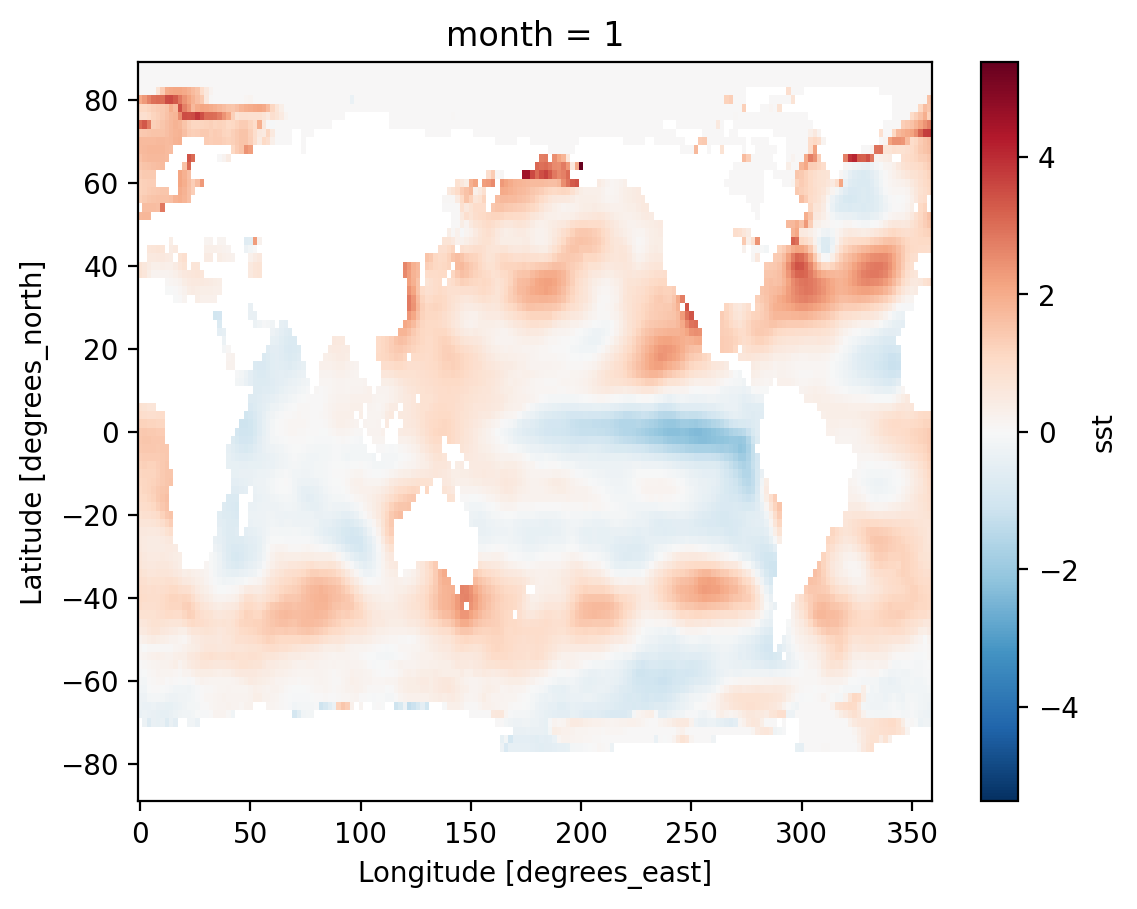

                                                                                                               
                                           Total time elapsed: 1.666 seconds                                   
                                        103 GPU function calls in 0.048 seconds                                
                                         3 CPU function calls in 0.013 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.get_loc     │ 0          │ 0.000       │ 0.000       │ 2          │ 0.013       │ 0.006       │
│ Float64Index.__len__      │ 80         │ 0.024       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 7          │ 0.015       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__    │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy         │ 6          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals       │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ isna                      │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- DatetimeIndex.get_loc
- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=170743;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [22]:
%%cudf.pandas.profile

(ds_anom.sel(time="2018-01-01") - ds_anom.sel(time="1970-01-01")).sst.plot();

```{exercise} 
:label: annual-mean

Using `groupby`, plot the annual mean time series of SST at 300°E, 50°N
```
````{solution} annual-mean
:class: dropdown
```python
ds.groupby("time.year").mean().sst.sel(lon=300, lat=50).plot();
```
````

## Resample

Resampling means changing the time frequency of data, usually reducing to a coarser frequency: e.g. converting daily frequency data to monthly frequency data using `mean` to reduce the values. This operation can be thought of as a groupby operation where each group is a single month of data. Resampling can be applied only to time-index dimensions. 

First note that `ds_anom` has data at monthly frequency (i.e. one point every month).

In [23]:
%%cudf.pandas.profile

ds_anom.time

<xarray.DataArray 'time' (time: 624)>
1970-01-01 1970-02-01 1970-03-01 1970-04-01 ... 2021-10-01 2021-11-01 2021-12-01
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes: (7)

                                                                                                               
                                           Total time elapsed: 0.319 seconds                                   
                                        254 GPU function calls in 0.096 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 174        │ 0.053       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 61         │ 0.019       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__    │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Here we compute the five-year mean along the `time` dimension by passing `time='5Y'`. `'5Y'` is a special frequency string. Xarray uses pandas to convert such a frequency string to a groupby operation. See the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for how to specify a different frequency.

In [24]:
%%cudf.pandas.profile

resample_obj = ds_anom.resample(time="5Y")
resample_obj

AttributeError: 'numpy.datetime64' object has no attribute 'replace'

                                                                                                                
                                           Total time elapsed: 9.043 seconds                                    
                                         50 GPU function calls in 0.021 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 25         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 6          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__    │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__       │ 12         │ 0.004       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names    │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.min          │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.max          │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{note}
`resample` only works with proper datetime64 coordinate labels. Note the `dtype` of `time` in the repr above.
```

Resampling objects are exactly like groupby objects and allow reductions, iteration, etc.

In [25]:
%%cudf.pandas.profile

ds_anom_resample = resample_obj.mean()
ds_anom_resample

NameError: name 'resample_obj' is not defined

                                                                                              
                                  Total time elapsed: 0.224 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [26]:
%%cudf.pandas.profile

for label, group in resample_obj:
    break
print(label, "\n\n", group)

NameError: name 'resample_obj' is not defined

                                                                                              
                                  Total time elapsed: 0.235 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

NameError: name 'ds_anom_resample' is not defined

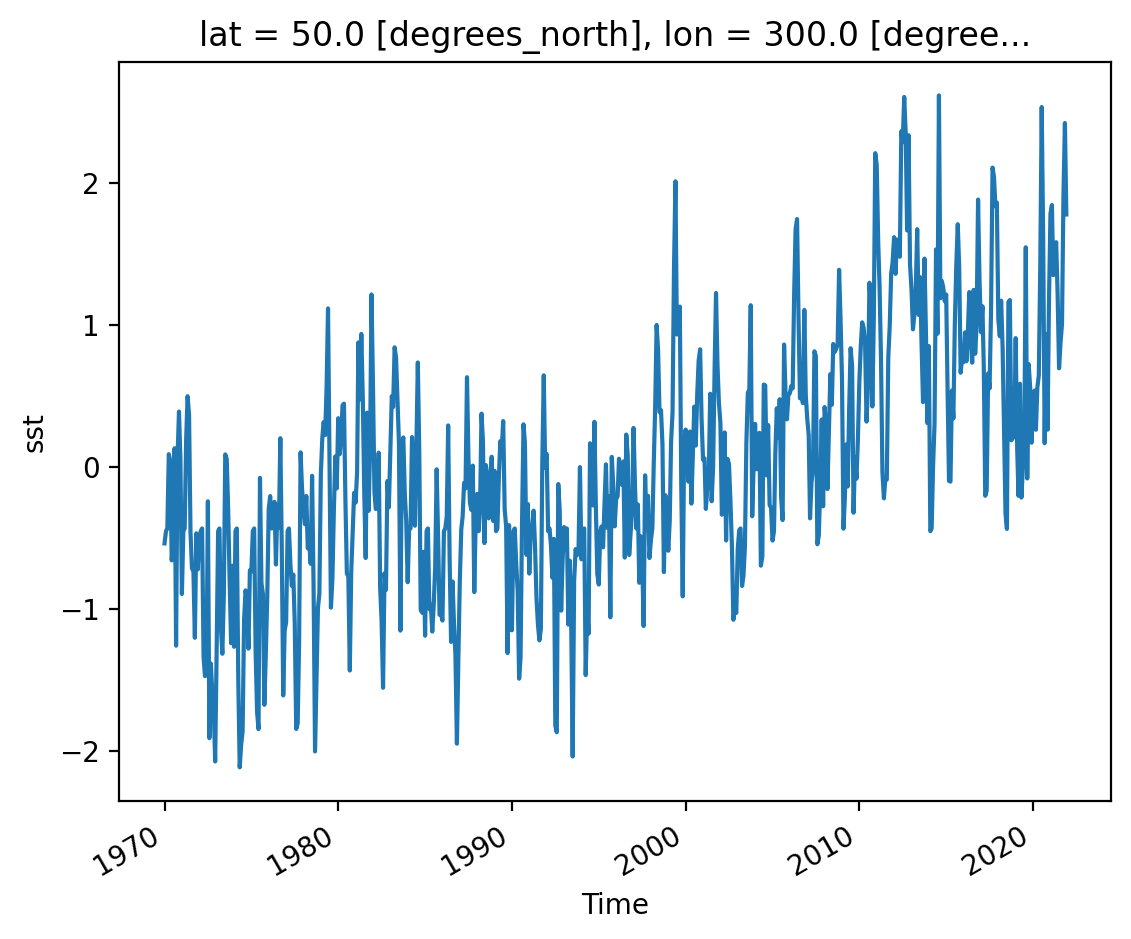

                                                                                                              
                                          Total time elapsed: 4.247 seconds                                   
                                        46 GPU function calls in 0.021 seconds                                
                                        1 CPU function calls in 0.008 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float64Index.__len__     │ 4          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__    │ 20         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 18         │ 0.005       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.get_loc     │ 1          │ 0.006       │ 0.006       │ 1          │ 0.008       │ 0.008       │
│ Float64Index.__getitem__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy       │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Float64Index.get_loc

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=376149;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [27]:
%%cudf.pandas.profile

ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker="o");

```{exercise}
:label: resample-mean

Using `resample`, plot the annual mean time series of SST at 300°E, 50°N.

Compare this output to the groupby output. What differences do you see?
```
````{solution} resample-mean
:class: dropdown
```python
resampled = ds.resample(time='Y').mean().sst.sel(lon=300, lat=50)
resampled.plot();
```
````

## GroupBy vs Resample 

Let's compare the grouped and resampled outputs.


1. Note the different dimension names: when grouped, `time` is renamed to `year`. When resampled, the `time` dimension name is preserved
2. The values for `year` are integers, while those for `resampled.time` are timestamps, similar to the input dataset
3. But all values are equal

In [28]:
%%cudf.pandas.profile

from IPython.display import display_html

grouped = ds.groupby("time.year").mean().sst.sel(lon=300, lat=50)
resampled = ds.resample(time='Y').mean().sst.sel(lon=300, lat=50)
display_html(grouped)
display_html(resampled)

AttributeError: 'numpy.datetime64' object has no attribute 'replace'

                                                                                                                
                                           Total time elapsed: 5.061 seconds                                    
                                        3574 GPU function calls in 1.524 seconds                                
                                         1 CPU function calls in 0.007 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 326        │ 0.117       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 57         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 3          │ 0.004       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 20         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 53         │ 0.158       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 222        │ 0.067       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__       │ 2126       │ 0.788       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy          │ 212        │ 0.081       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals        │ 306        │ 0.137       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__len__         │ 23         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.set_names     │ 204        │ 0.113       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.copy            │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ RangeIndex.__setattr__     │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__setattr__   │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__     │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.get_loc       │ 1          │ 0.004       │ 0.004       │ 1          │ 0.007       │ 0.007       │
│ Float64Index.__getitem__   │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names    │ 1          │ 0

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Float64Index.get_loc

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=97848;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [29]:
%%cudf.pandas.profile

np.array_equal(grouped.data, resampled.data)

NameError: name 'resampled' is not defined

                                                                                              
                                  Total time elapsed: 0.217 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

## Going further

1. See the documentation on [groupby](https://docs.xarray.dev/en/stable/user-guide/groupby.html) and [resample](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
2. Follow the tutorial on [high-level computation patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html)